# Navigation

---

In this notebook, I provide my solution codes to the first project of the [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) which uses the Unity ML-Agents environment.

 

### 0. Start the Environment

We begin by importing some necessary packages, and initializing the environment as well as the game agent.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import deque
from dqn_agent import Agent
from unityagents import UnityEnvironment

%matplotlib inline

# initiate the environment
env = UnityEnvironment(file_name="Banana.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# get number of actions
action_size = brain.vector_action_space_size

# get state size 
state = env_info.vector_observations[0]
state_size = len(state)

# initialize the game agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 1. Show the network archetecture and hyperparameters

The DQN agent uses neural network to process the state inputs and produce action outputs. The agents uses two neural networks including `qnetwork_local` and `qnetwork_target`. All of the networks consists of only fully-connected layers gated by ReLu layers, except the output layer which output a single Q-value and is not gated by ReLu.

Hidden layer sizes and the number of layers is printed below for reference. For further details about the network archetecture, please refer to the files `model.py` and `ddpg_agent.py`

In [2]:
print('Archetecture of the local Deep Q-Network: \n', agent.qnetwork_local, '\n')
print('Archetecture of the target Deep Q-Network: \n', agent.qnetwork_target, '\n')

Archetecture of the local Deep Q-Network: 
 QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
) 

Archetecture of the target Deep Q-Network: 
 QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
) 



### 2. Define training details

#### The Learning Algorithm
This is the step where the DQN agent is trained through interacting with the envrionment and learns the best behavioral policy.

As shown in the previous step, the agent uses two neural networks to do this job. The `qnetwork_local` network is the one used in the agent's interactions with the environment and the `qnetwork_target` network is used only in learning steps to stablize the training.

The agent first interacts with the environment randomly, and collects experience data in the tuple form of `state, action, reward, next state, end-of-episode`. These experiences are then stored at the agent's memory which is a `deque` object with a max size of `BUFFER_SIZE`.

The learning happens when the agent samples experience data from it's memory, and uses it's `qnetwork_local` network's optimizer (Adam optimizer in this project) to minimizes the MSE error between the Q-values predicted by the network and the true rewards received by the agent in the Temperal Difference fashion. This is implemented in the `learn()` function of the `Agent` class in the `dqn_agent.py` file.

The agent gradually decreases it's liklihood of chosing random actions, and exploits the knowledge learned by the `qnetwork_local` by chosing the action with the maximum Q-value. This allows the agent to fine tune the Q-value predictions produced by the neural network. The likelihood of the agent's random action is the `eps` variable in below training algorithm, which decreases exponentially with a factor of `eps_decay` in the training process.

In the end, the agent sets the `eps` to zero and evaluates it's performance by only exploiting the Q-values learned by the agent, and reports the rewards it receives.

#### The training hyperparameters
- BUFFER_SIZE = int(1e5): replay buffer size
- BATCH_SIZE = 64: minibatch size
- GAMMA = 0.99: discount factor
- TAU = 1e-3: for soft update of target parameters
- LR = 5e-4: learning rate 
- UPDATE_EVERY = 4: how often to update the network

In [3]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                  .format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

### 3. Start the training and plot the scores

Episode 100	Average Score: 1.31
Episode 200	Average Score: 4.71
Episode 300	Average Score: 8.46
Episode 400	Average Score: 10.79
Episode 500	Average Score: 12.60
Episode 535	Average Score: 13.00
Environment solved in 535 episodes!	Average Score: 13.00


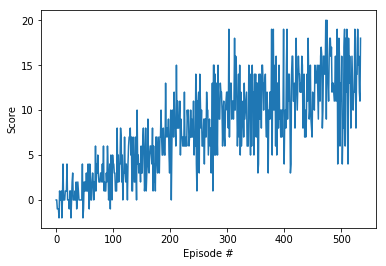

In [4]:
# start training
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Evaluate the performance of the trained model

In [6]:
# load the trained network weights
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Single episode agent score after training: {}".format(score))
env.close()

Single episode agent score after training: 14.0


### 5. Ideas for future work

- Prioritized Experience Replay
- Dueling Deep Q Networks
- Learning from pixels